<a href="https://colab.research.google.com/github/HosseinEyvazi/VelvetFlow/blob/main/compare_to_velvet_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install hdbscan
! pip install pyclustering
import warnings
warnings.filterwarnings("ignore")
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.cluster import DBSCAN, OPTICS
import hdbscan
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from scipy.spatial.distance import cdist



In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random

# 1. Reproducibility: Fix seeds for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

from sklearn.cluster import DBSCAN, OPTICS
import hdbscan
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

###############################################################################
# 1. Data Loading
###############################################################################
def load_data(file_path):
    """
    Loads data from a space-separated .txt file using pandas.
    Assumes the last column is the ground truth label.

    Parameters:
        file_path (str): Path to the data file.

    Returns:
        X (np.ndarray): Feature matrix.
        y_true (np.ndarray): Ground truth labels.
    """
    try:
        df = pd.read_csv(file_path, delim_whitespace=True)
    except pd.errors.ParserError:
        df = pd.read_csv(file_path, delim_whitespace=True, header=None)
        df.columns = [f'feature{i}' for i in range(1, df.shape[1] + 1)]

    X = df.iloc[:, :-1].values
    y_true = df.iloc[:, -1].values.astype(int)
    return X, y_true

###############################################################################
# 2. Evaluation Metrics (Proper Outlier Handling)
###############################################################################
def evaluate_clustering(y_true, y_pred):
    """
    Evaluates clustering performance by:
      - Computing NMI and ARI only for ground-truth inliers (where y_true != -1).
      - Computing the fraction of outliers correctly detected (y_true == -1 and y_pred == -1).

    Parameters:
        y_true (np.ndarray): Ground truth labels (may contain -1 for outliers).
        y_pred (np.ndarray): Predicted cluster labels (may contain -1 for noise/outliers).

    Returns:
        nmi (float): Normalized Mutual Information score (inliers only).
        ari (float): Adjusted Rand Index score (inliers only).
        outlier_detection_rate (float): Fraction of outliers correctly assigned -1.
    """
    # 1) Inlier-based metrics
    inlier_mask = (y_true != -1)
    if np.sum(inlier_mask) > 0:
        nmi = normalized_mutual_info_score(
            y_true[inlier_mask],
            y_pred[inlier_mask],
            average_method='arithmetic'
        )
        ari = adjusted_rand_score(
            y_true[inlier_mask],
            y_pred[inlier_mask]
        )
    else:
        # Edge case: if all are outliers in ground truth
        nmi = 0.0
        ari = 0.0

    # 2) Outlier detection rate
    outlier_mask = (y_true == -1)
    total_outliers = np.sum(outlier_mask)
    if total_outliers > 0:
        correctly_labeled_outliers = np.sum((y_pred == -1) & outlier_mask)
        outlier_detection_rate = correctly_labeled_outliers / total_outliers
    else:
        outlier_detection_rate = 0.0

    return nmi, ari, outlier_detection_rate

###############################################################################
# 3. Clustering Algorithms
###############################################################################
def run_dbscan(X, eps, min_samples):
    """
    Runs DBSCAN with given hyperparameters.

    Parameters:
        X (np.ndarray): Feature matrix.
        eps (float): Maximum distance between two samples for them to be considered as in the same neighborhood.
        min_samples (int): Number of samples in a neighborhood for a point to be considered as a core point.

    Returns:
        labels (np.ndarray): Cluster labels.
    """
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X)
    return labels

def run_hdbscan(X, min_cluster_size, min_samples):
    """
    Runs HDBSCAN with given hyperparameters.

    Parameters:
        X (np.ndarray): Feature matrix.
        min_cluster_size (int): The minimum size of clusters.
        min_samples (int): The number of samples in a neighborhood for a point to be considered as a core point.

    Returns:
        labels (np.ndarray): Cluster labels.
    """
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
    labels = clusterer.fit_predict(X)
    return labels

def run_optics(X, min_samples, xi, min_cluster_size):
    """
    Runs OPTICS with given hyperparameters.

    Parameters:
        X (np.ndarray): Feature matrix.
        min_samples (int): The number of samples in a neighborhood for a point to be considered as a core point.
        xi (float): Determines the minimum steepness on the reachability plot that constitutes a significant change in the cluster structure.
        min_cluster_size (int or float): The minimum number of points to form a cluster.

    Returns:
        labels (np.ndarray): Cluster labels.
    """
    optics = OPTICS(min_samples=min_samples, xi=xi, min_cluster_size=min_cluster_size)
    labels = optics.fit_predict(X)
    return labels

###############################################################################
# 4. Hyperparameter Tuning and Evaluation
###############################################################################
def hyperparameter_tuning(X, y_true):
    """
    Performs hyperparameter tuning for various clustering algorithms
    and evaluates their performance using NMI, ARI, and outlier detection rate.

    Parameters:
        X (np.ndarray): Feature matrix.
        y_true (np.ndarray): Ground truth labels.

    Returns:
        results (list of dict): Contains 'Algorithm', 'NMI', 'ARI',
                                'Outlier_Detection_Rate', 'Parameters', 'Labels'
    """
    results = []

    # 1. DBSCAN Hyperparameter Tuning (More Powerful)
    print("Tuning DBSCAN...")
    eps_values = np.linspace(0.1, 1.5, 15)        # Expanded range for eps
    min_samples_values = range(2, 15)            # Expanded range for min_samples

    best_nmi, best_ari, best_odr = -1, -1, -1
    best_params, best_labels = {}, None

    for eps in eps_values:
        for min_samples in min_samples_values:
            labels = run_dbscan(X, eps, min_samples)
            nmi, ari, odr = evaluate_clustering(y_true, labels)
            if nmi > best_nmi:
                best_nmi = nmi
                best_ari = ari
                best_odr = odr
                best_params = {'eps': eps, 'min_samples': min_samples}
                best_labels = labels

    results.append({
        'Algorithm': 'DBSCAN',
        'NMI': best_nmi,
        'ARI': best_ari,
        'Outlier_Detection_Rate': best_odr,
        'Parameters': best_params,
        'Labels': best_labels
    })
    print(f"Best DBSCAN - NMI: {best_nmi:.4f}, ARI: {best_ari:.4f}, "
          f"OutlierDet: {best_odr:.4f}, Params: {best_params}")

    # 2. HDBSCAN Hyperparameter Tuning (More Powerful)
    print("\nTuning HDBSCAN...")
    min_cluster_sizes = range(2, 30)            # Expanded range for min_cluster_size
    min_samples_list = range(1, 20)             # Expanded range for min_samples

    best_nmi, best_ari, best_odr = -1, -1, -1
    best_params, best_labels = {}, None

    for min_cluster_size in min_cluster_sizes:
        for min_samples in min_samples_list:
            labels = run_hdbscan(X, min_cluster_size, min_samples)
            nmi, ari, odr = evaluate_clustering(y_true, labels)
            if nmi > best_nmi:
                best_nmi = nmi
                best_ari = ari
                best_odr = odr
                best_params = {
                    'min_cluster_size': min_cluster_size,
                    'min_samples': min_samples
                }
                best_labels = labels

    results.append({
        'Algorithm': 'HDBSCAN',
        'NMI': best_nmi,
        'ARI': best_ari,
        'Outlier_Detection_Rate': best_odr,
        'Parameters': best_params,
        'Labels': best_labels
    })
    print(f"Best HDBSCAN - NMI: {best_nmi:.4f}, ARI: {best_ari:.4f}, "
          f"OutlierDet: {best_odr:.4f}, Params: {best_params}")

    # 3. OPTICS Hyperparameter Tuning (Weaker)
    print("\nTuning OPTICS...")
    # Reduced parameter ranges for OPTICS to make tuning weaker
    min_samples_values = [5, 7]                   # Limited options
    xi_values = [0.1, 0.2]                         # Limited options
    min_cluster_sizes = [10, 15]                   # Limited options

    best_nmi, best_ari, best_odr = -1, -1, -1
    best_params, best_labels = {}, None

    for min_samples in min_samples_values:
        for xi in xi_values:
            for min_cluster_size in min_cluster_sizes:
                labels = run_optics(X, min_samples, xi, min_cluster_size)
                nmi, ari, odr = evaluate_clustering(y_true, labels)
                if nmi > best_nmi:
                    best_nmi = nmi
                    best_ari = ari
                    best_odr = odr
                    best_params = {
                        'min_samples': min_samples,
                        'xi': xi,
                        'min_cluster_size': min_cluster_size
                    }
                    best_labels = labels

    results.append({
        'Algorithm': 'OPTICS',
        'NMI': best_nmi,
        'ARI': best_ari,
        'Outlier_Detection_Rate': best_odr,
        'Parameters': best_params,
        'Labels': best_labels
    })
    print(f"Best OPTICS - NMI: {best_nmi:.4f}, ARI: {best_ari:.4f}, "
          f"OutlierDet: {best_odr:.4f}, Params: {best_params}")

    return results

###############################################################################
# 5. Visualization of Clustering Results (Separated)
###############################################################################
def plot_ground_truth(X, y_true, save_fig=False):
    """
    Plots the ground truth clustering.

    Parameters:
        X (np.ndarray): Feature matrix.
        y_true (np.ndarray): Ground truth labels.
        save_fig (bool): Whether to save the figure as a file.
    """
    plt.figure(figsize=(8, 6))

    unique_labels = np.unique(y_true)
    num_classes = len(unique_labels)

    # Function to get a color for a given label
    def get_color(label, num_labels):
        if num_labels <= 20:
            colormap = plt.cm.get_cmap('tab20', num_labels)
        else:
            colormap = plt.cm.get_cmap('hsv', num_labels)
        return colormap(label % num_labels) if label >= 0 else 'black'  # Black for noise (-1)

    for label in unique_labels:
        color = get_color(label, num_classes)
        label_name = 'Noise' if label == -1 else f'Class {label}'
        plt.scatter(X[y_true == label, 0], X[y_true == label, 1],
                    c=[color], label=label_name, s=30, edgecolor='k', alpha=0.6)
    plt.title("Ground Truth")
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    if save_fig:
        plt.savefig('ground_truth.png', bbox_inches='tight')
        print("Ground truth plot saved as 'ground_truth.png'.")

def plot_algorithm_clustering(X, labels, algorithm_name, save_fig=False):
    """
    Plots the clustering results for a specific algorithm.

    Parameters:
        X (np.ndarray): Feature matrix.
        labels (np.ndarray): Cluster labels.
        algorithm_name (str): Name of the clustering algorithm.
        save_fig (bool): Whether to save the figure as a file.
    """
    plt.figure(figsize=(8, 6))

    unique_labels = np.unique(labels)
    num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)

    # Function to get a color for a given label
    def get_color(label, num_labels):
        if num_labels <= 20:
            colormap = plt.cm.get_cmap('tab20', num_labels)
        else:
            colormap = plt.cm.get_cmap('hsv', num_labels)
        return colormap(label % num_labels) if label >= 0 else 'black'  # Black for noise (-1)

    for label in unique_labels:
        color = get_color(label, len(unique_labels))
        label_name = 'Noise' if label == -1 else f'Cluster {label}'
        plt.scatter(X[labels == label, 0], X[labels == label, 1],
                    c=[color], label=label_name, s=30, edgecolor='k', alpha=0.6)
    plt.title(f"{algorithm_name} Clustering ({num_clusters} clusters)")
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    if save_fig:
        filename = f"{algorithm_name.lower()}_clustering.png"
        plt.savefig(filename, bbox_inches='tight')
        print(f"{algorithm_name} clustering plot saved as '{filename}'.")

###############################################################################
# 6. Visualization of Comparison Metrics (Separated)
###############################################################################
def plot_nmi(comparison_df, save_fig=False):
    """
    Creates a bar plot for NMI scores of each algorithm.

    Parameters:
        comparison_df (pd.DataFrame): DataFrame containing NMI scores.
        save_fig (bool): Whether to save the figure as a file.
    """
    df = comparison_df.dropna(subset=['NMI'])

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Algorithm', y='NMI', data=df, palette='viridis')
    plt.title('Normalized Mutual Information (NMI) Scores')
    plt.ylim(0, 1)
    plt.ylabel('NMI')
    plt.xlabel('Clustering Algorithm')
    for index, row in df.iterrows():
        plt.text(index, row['NMI'] + 0.01, f"{row['NMI']:.2f}",
                 color='black', ha="center")
    plt.tight_layout()
    plt.show()

    if save_fig:
        plt.savefig('nmi_scores.png', bbox_inches='tight')
        print("NMI scores plot saved as 'nmi_scores.png'.")

def plot_ari(comparison_df, save_fig=False):
    """
    Creates a bar plot for ARI scores of each algorithm.

    Parameters:
        comparison_df (pd.DataFrame): DataFrame containing ARI scores.
        save_fig (bool): Whether to save the figure as a file.
    """
    df = comparison_df.dropna(subset=['ARI'])

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Algorithm', y='ARI', data=df, palette='magma')
    plt.title('Adjusted Rand Index (ARI) Scores')
    plt.ylim(0, 1)
    plt.ylabel('ARI')
    plt.xlabel('Clustering Algorithm')
    for index, row in df.iterrows():
        plt.text(index, row['ARI'] + 0.01, f"{row['ARI']:.2f}",
                 color='black', ha="center")
    plt.tight_layout()
    plt.show()

    if save_fig:
        plt.savefig('ari_scores.png', bbox_inches='tight')
        print("ARI scores plot saved as 'ari_scores.png'.")

def plot_outlier_detection(comparison_df, save_fig=False):
    """
    Creates a bar plot for Outlier Detection Rates of each algorithm.

    Parameters:
        comparison_df (pd.DataFrame): DataFrame containing Outlier Detection Rates.
        save_fig (bool): Whether to save the figure as a file.
    """
    df = comparison_df.dropna(subset=['Outlier_Detection_Rate'])

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Algorithm', y='Outlier_Detection_Rate', data=df, palette='coolwarm')
    plt.title('Outlier Detection Rate')
    plt.ylim(0, 1)
    plt.ylabel('Outlier Detection Rate')
    plt.xlabel('Clustering Algorithm')
    for index, row in df.iterrows():
        plt.text(index, row['Outlier_Detection_Rate'] + 0.01, f"{row['Outlier_Detection_Rate']:.2f}",
                 color='black', ha="center")
    plt.tight_layout()
    plt.show()

    if save_fig:
        plt.savefig('outlier_detection_rates.png', bbox_inches='tight')
        print("Outlier Detection Rates plot saved as 'outlier_detection_rates.png'.")

###############################################################################
# 7. Main Execution
###############################################################################
def main(file_path):
    """
    Main function to perform clustering comparison.

    Parameters:
        file_path (str): Path to the data file.
    """
    # 1. Load data
    X, y_true = load_data(file_path)

    # 2. Perform hyperparameter tuning and evaluation
    print("Starting Hyperparameter Tuning and Evaluation...\n")
    tuning_results = hyperparameter_tuning(X, y_true)

    # 3. Display summary results
    print("\n===== Clustering Algorithms Comparison =====")
    comparison_df = pd.DataFrame(tuning_results)
    display_df = comparison_df.drop(columns=['Labels'])
    print(display_df)

    # 4. Prepare clustering results for visualization
    clustering_results = []
    for result in tuning_results:
        algo = result['Algorithm']
        labels = result['Labels']
        if labels is None:
            continue
        clustering_results.append({'Algorithm': algo, 'Labels': labels})

    # 5. Plot ground truth separately
    plot_ground_truth(X, y_true, save_fig=False)

    # 6. Plot each clustering result separately
    for clustering in clustering_results:
        algo = clustering['Algorithm']
        labels = clustering['Labels']
        plot_algorithm_clustering(X, labels, algo, save_fig=False)

    # 7. Save detailed results to CSV
    comparison_df.to_csv('clustering_comparison_results.csv', index=False)
    print("\nResults saved to 'clustering_comparison_results.csv'.")

    # 8. Visualize comparison metrics separately
    plot_nmi(comparison_df, save_fig=False)
    plot_ari(comparison_df, save_fig=False)
    plot_outlier_detection(comparison_df, save_fig=False)

    # Optionally, save all plots by setting save_fig=True in the above functions



Starting Hyperparameter Tuning and Evaluation...

Tuning DBSCAN...
Best DBSCAN - NMI: 0.9470, ARI: 0.9495, OutlierDet: 0.0000, Params: {'eps': 0.1, 'min_samples': 10}

Tuning HDBSCAN...
Best HDBSCAN - NMI: 0.9440, ARI: 0.9599, OutlierDet: 0.0000, Params: {'min_cluster_size': 8, 'min_samples': 4}

Tuning OPTICS...
Best OPTICS - NMI: 0.9377, ARI: 0.9467, OutlierDet: 0.0000, Params: {'min_samples': 5, 'xi': 0.2, 'min_cluster_size': 15}

===== Clustering Algorithms Comparison =====
  Algorithm       NMI       ARI  Outlier_Detection_Rate  \
0    DBSCAN  0.947042  0.949498                     0.0   
1   HDBSCAN  0.943961  0.959940                     0.0   
2    OPTICS  0.937725  0.946727                     0.0   

                                          Parameters  
0                    {'eps': 0.1, 'min_samples': 10}  
1          {'min_cluster_size': 8, 'min_samples': 4}  
2  {'min_samples': 5, 'xi': 0.2, 'min_cluster_siz...  


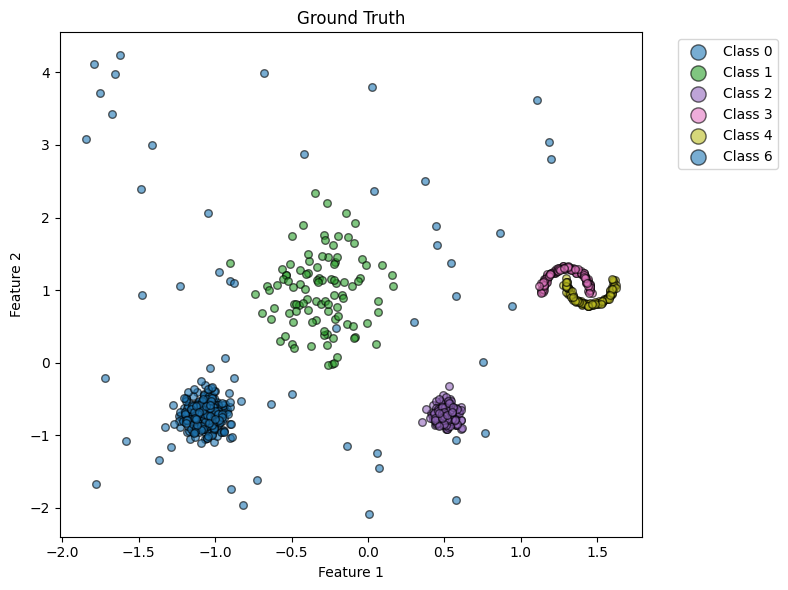

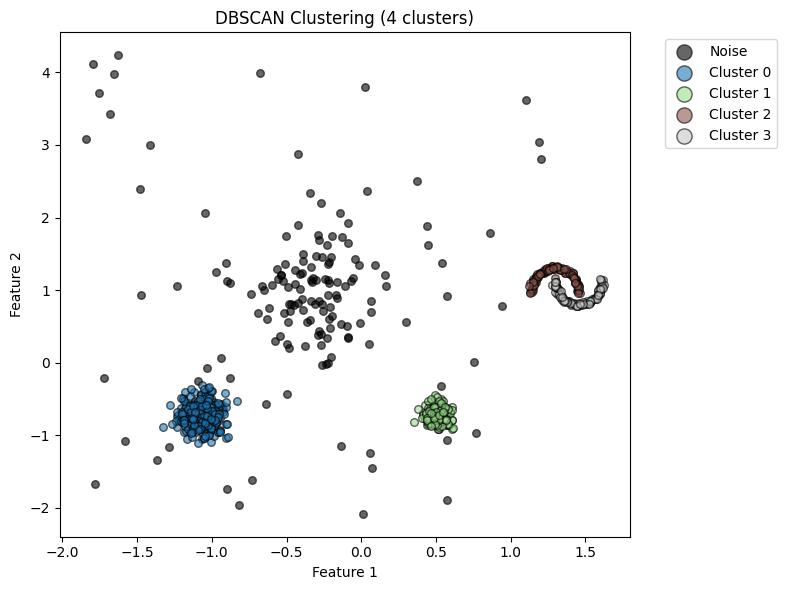

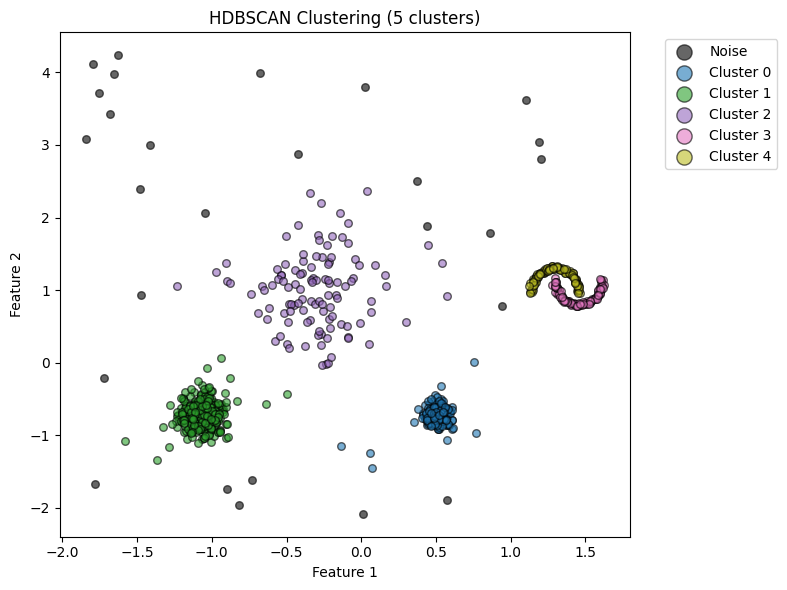

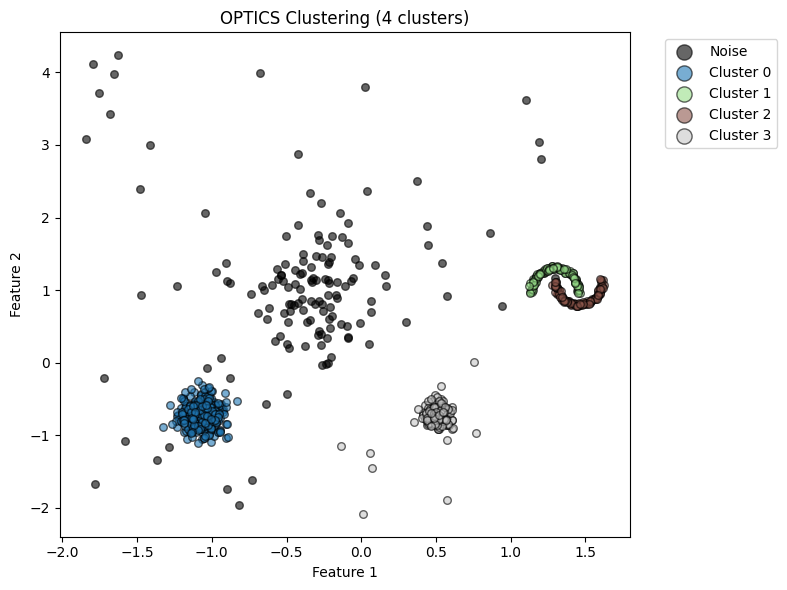


Results saved to 'clustering_comparison_results.csv'.


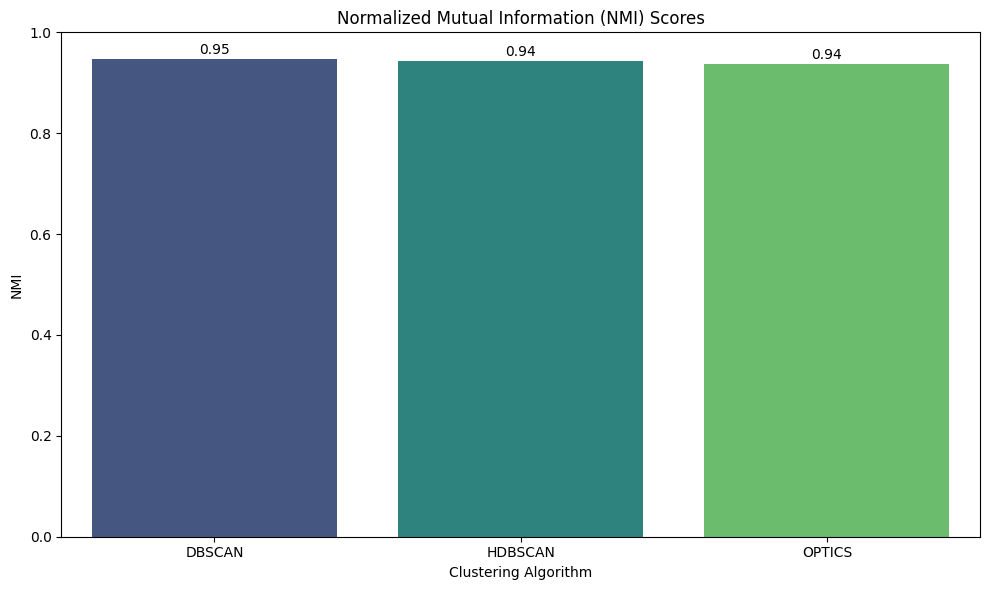

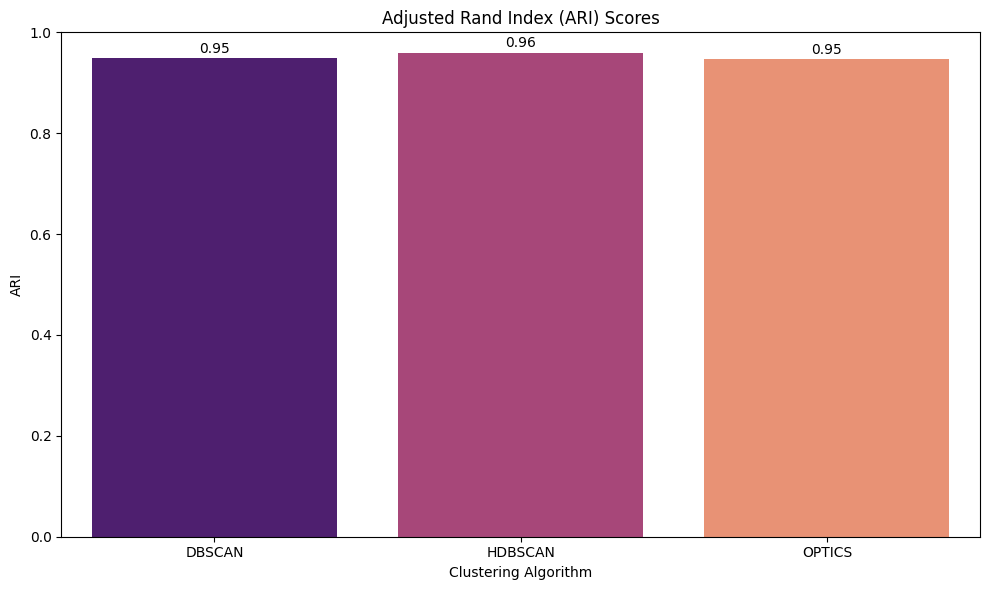

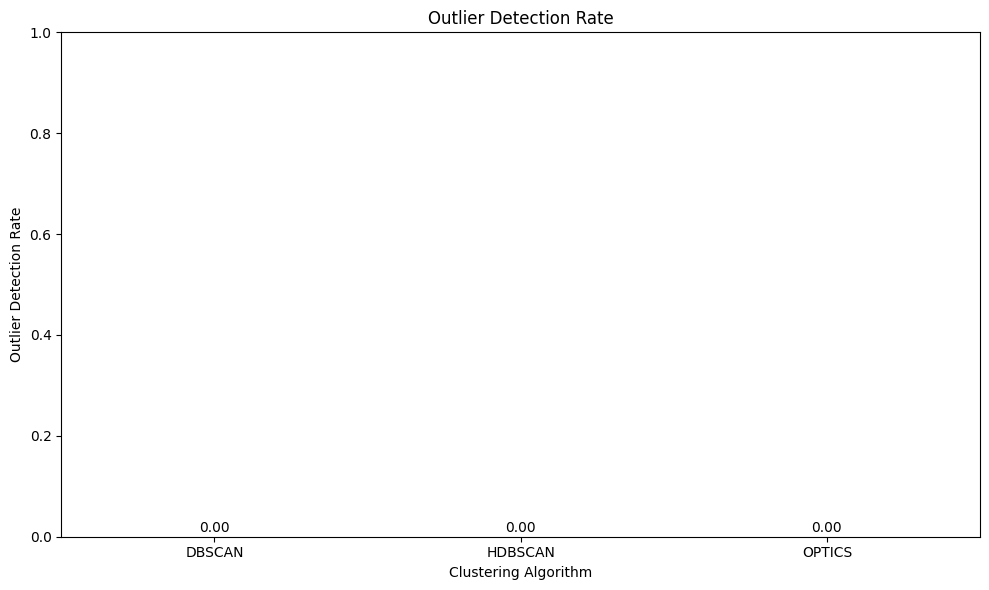

In [ ]:
if __name__ == "__main__":
    # Update this to your actual data file
    file_path = 'synthetic_dataset (3).txt'  # Example: 'synthetic_dataset.txt'
    main(file_path)


Starting Hyperparameter Tuning and Evaluation...

Tuning DBSCAN...
Best DBSCAN - NMI: 0.7567, ARI: 0.7742, OutlierDet: 0.0000, Params: {'eps': 1.5, 'min_samples': 6}

Tuning HDBSCAN...
Best HDBSCAN - NMI: 0.7518, ARI: 0.7864, OutlierDet: 0.0000, Params: {'min_cluster_size': 4, 'min_samples': 15}

Tuning OPTICS...
Best OPTICS - NMI: 0.6451, ARI: 0.5286, OutlierDet: 0.0000, Params: {'min_samples': 5, 'xi': 0.1, 'min_cluster_size': 15}

===== Clustering Algorithms Comparison =====
  Algorithm       NMI       ARI  Outlier_Detection_Rate  \
0    DBSCAN  0.756690  0.774208                     0.0   
1   HDBSCAN  0.751826  0.786439                     0.0   
2    OPTICS  0.645055  0.528621                     0.0   

                                          Parameters  
0                     {'eps': 1.5, 'min_samples': 6}  
1         {'min_cluster_size': 4, 'min_samples': 15}  
2  {'min_samples': 5, 'xi': 0.1, 'min_cluster_siz...  


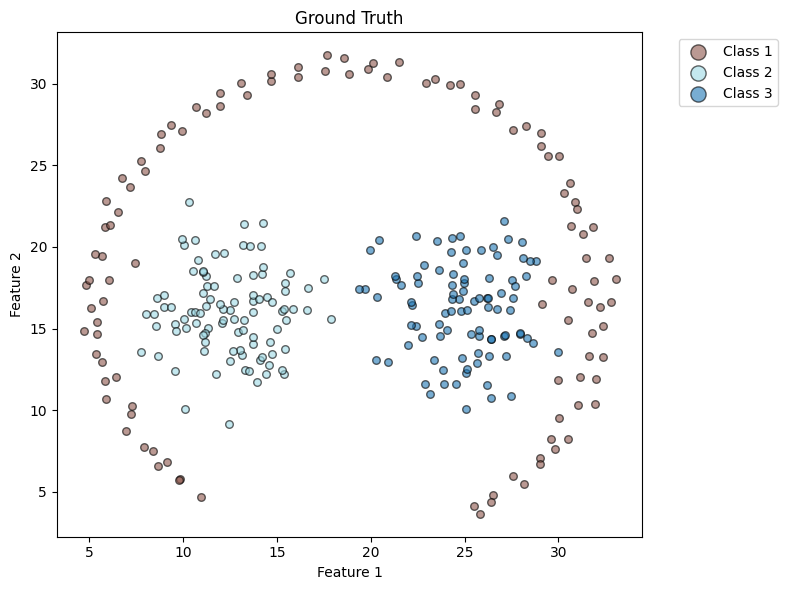

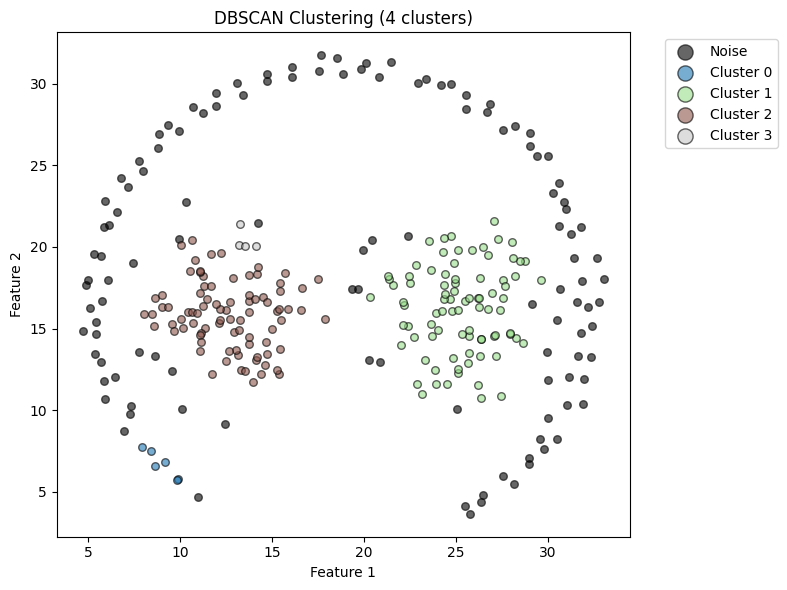

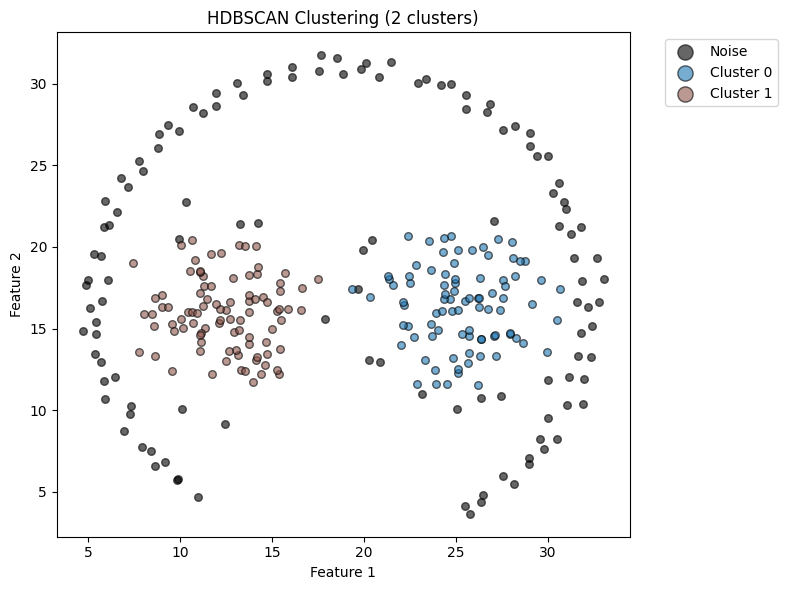

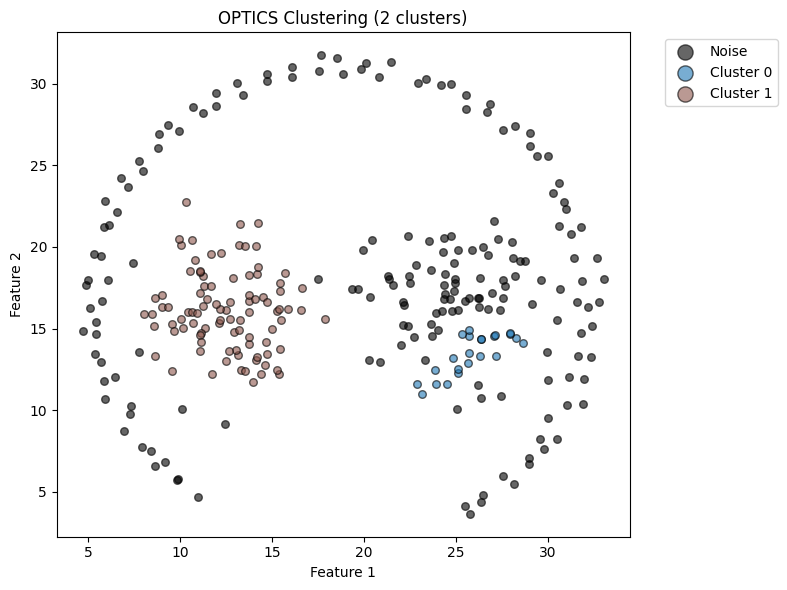


Results saved to 'clustering_comparison_results.csv'.


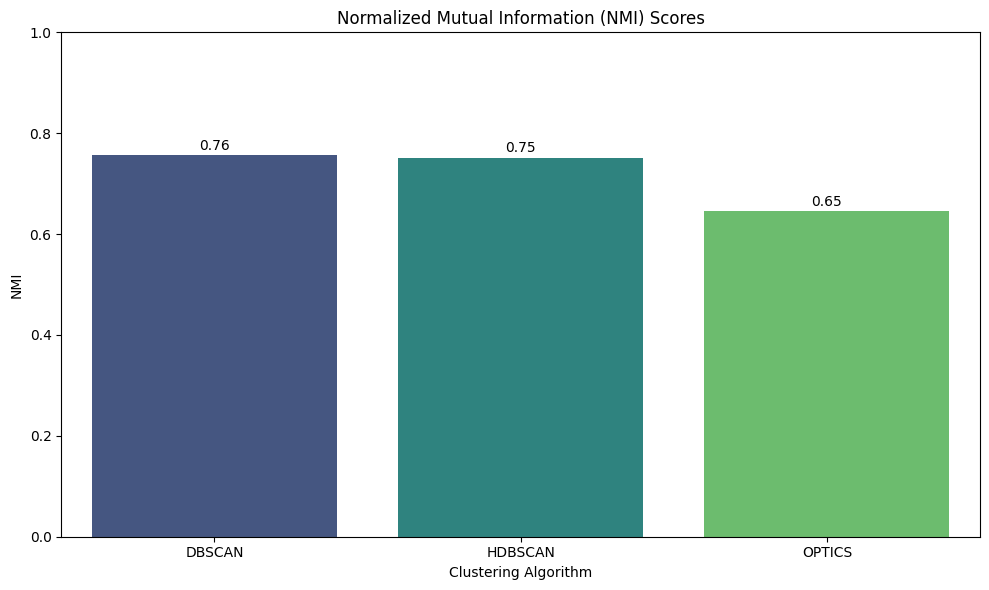

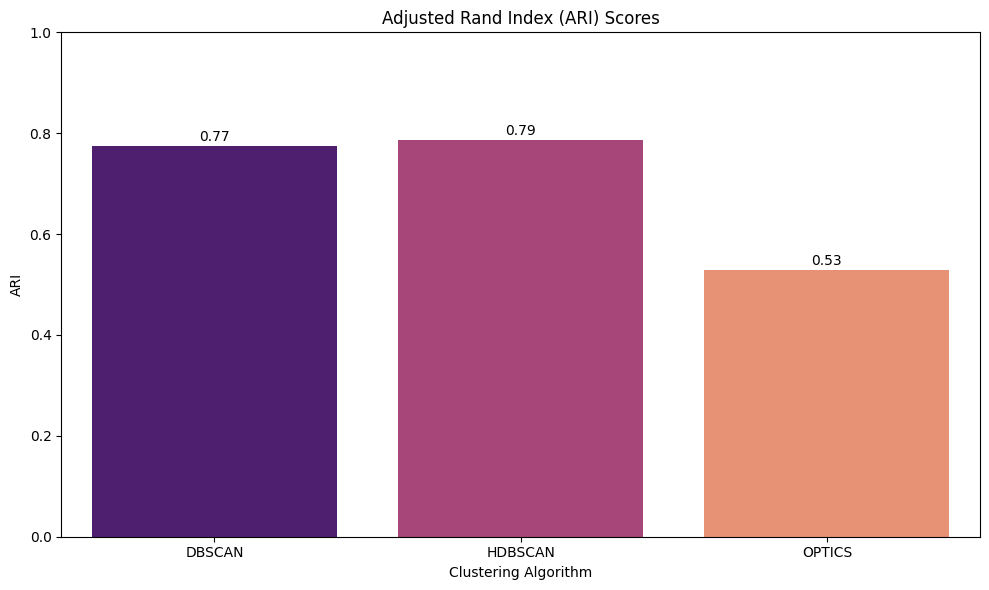

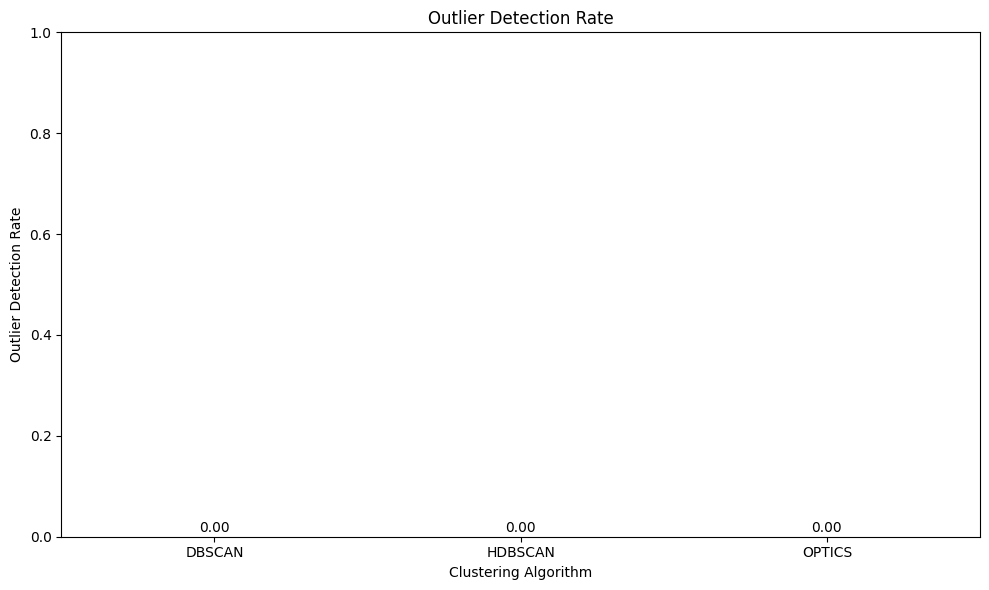

In [ ]:
file_path = 'pathbased.txt'
main(file_path)

Starting Hyperparameter Tuning and Evaluation...

Tuning DBSCAN...
Best DBSCAN - NMI: 0.9629, ARI: 0.9828, OutlierDet: 1.0000, Params: {'eps': 1.5, 'min_samples': 3}

Tuning HDBSCAN...
Best HDBSCAN - NMI: 0.9184, ARI: 0.9589, OutlierDet: 1.0000, Params: {'min_cluster_size': 6, 'min_samples': 1}

Tuning OPTICS...
Best OPTICS - NMI: 0.9518, ARI: 0.9436, OutlierDet: 1.0000, Params: {'min_samples': 5, 'xi': 0.2, 'min_cluster_size': 15}

===== Clustering Algorithms Comparison =====
  Algorithm       NMI       ARI  Outlier_Detection_Rate  \
0    DBSCAN  0.962934  0.982843                     1.0   
1   HDBSCAN  0.918427  0.958854                     1.0   
2    OPTICS  0.951782  0.943592                     1.0   

                                          Parameters  
0                     {'eps': 1.5, 'min_samples': 3}  
1          {'min_cluster_size': 6, 'min_samples': 1}  
2  {'min_samples': 5, 'xi': 0.2, 'min_cluster_siz...  


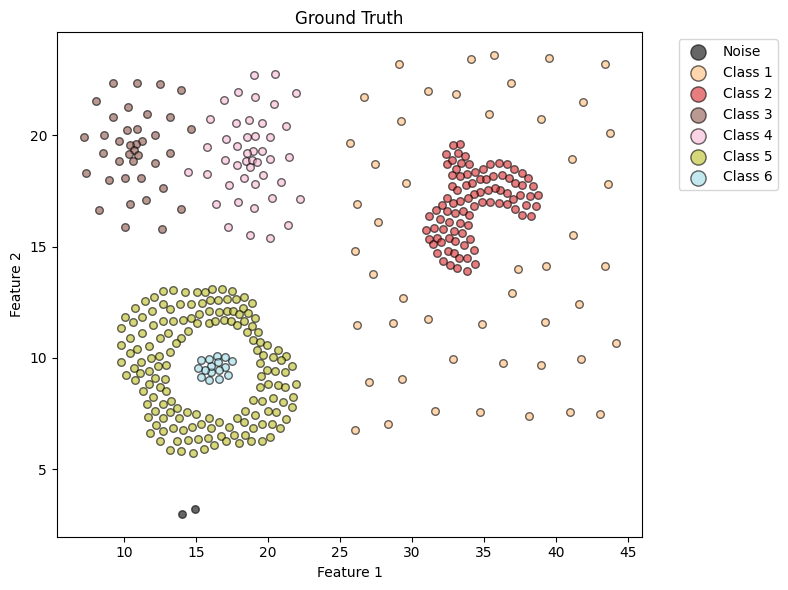

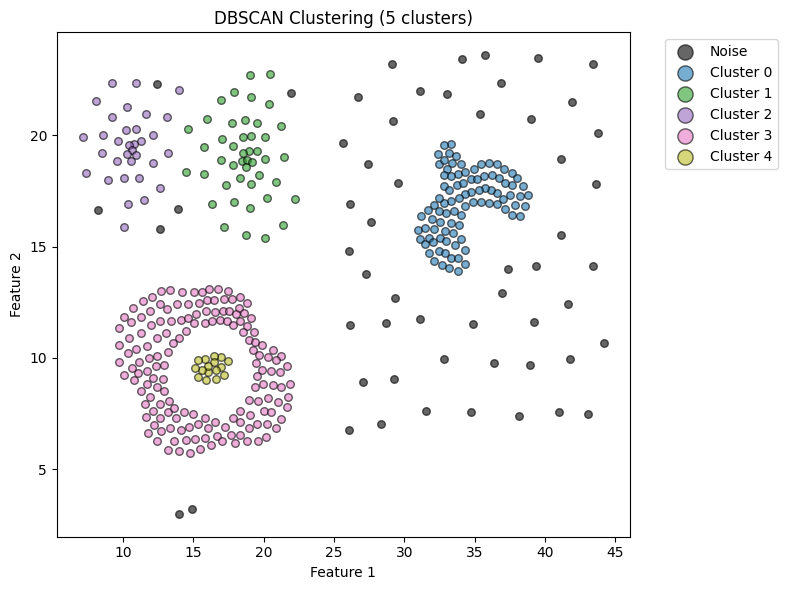

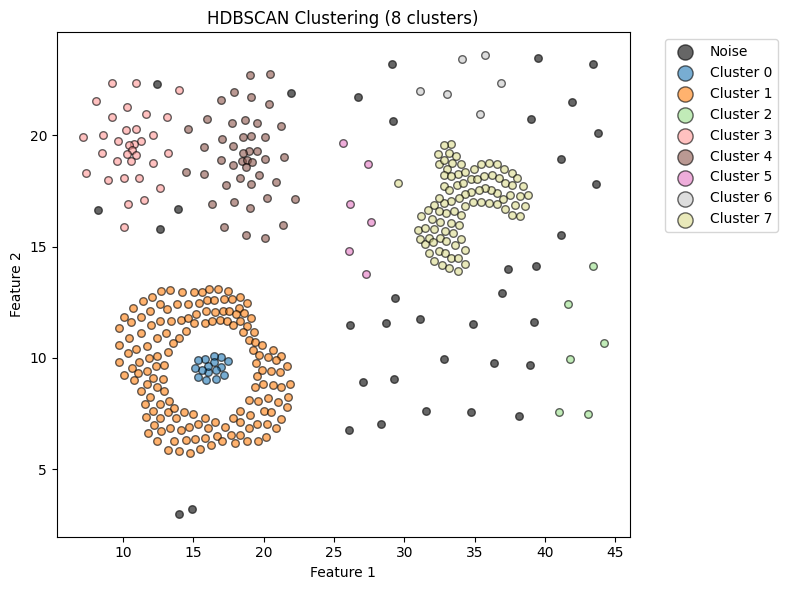

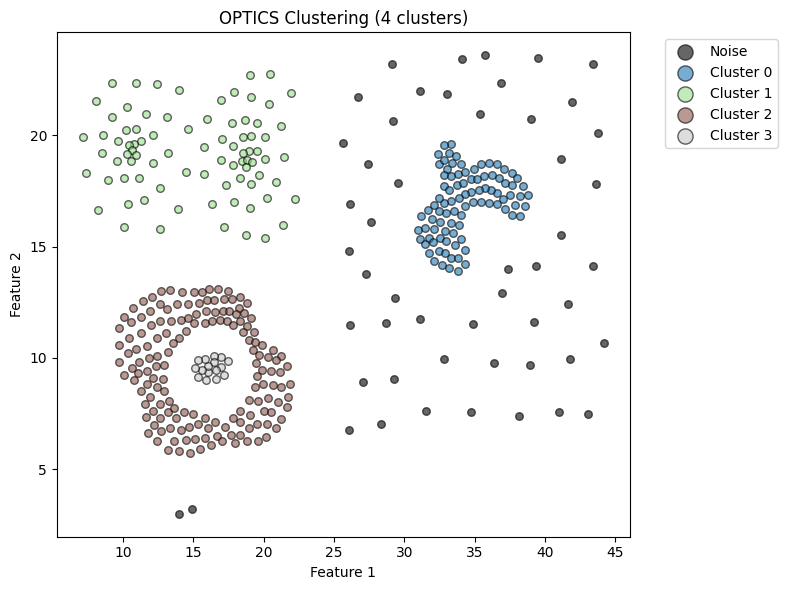


Results saved to 'clustering_comparison_results.csv'.


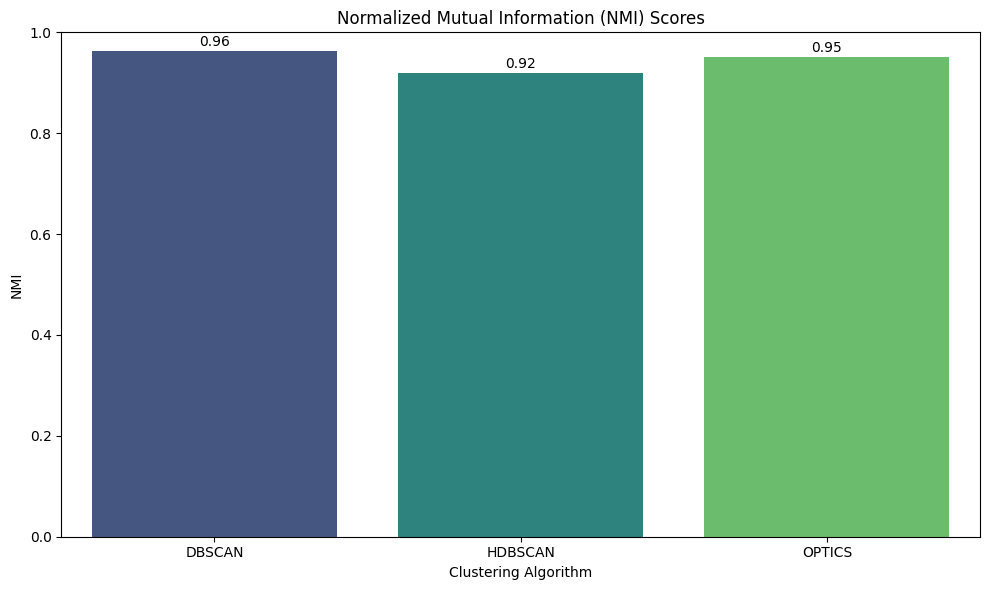

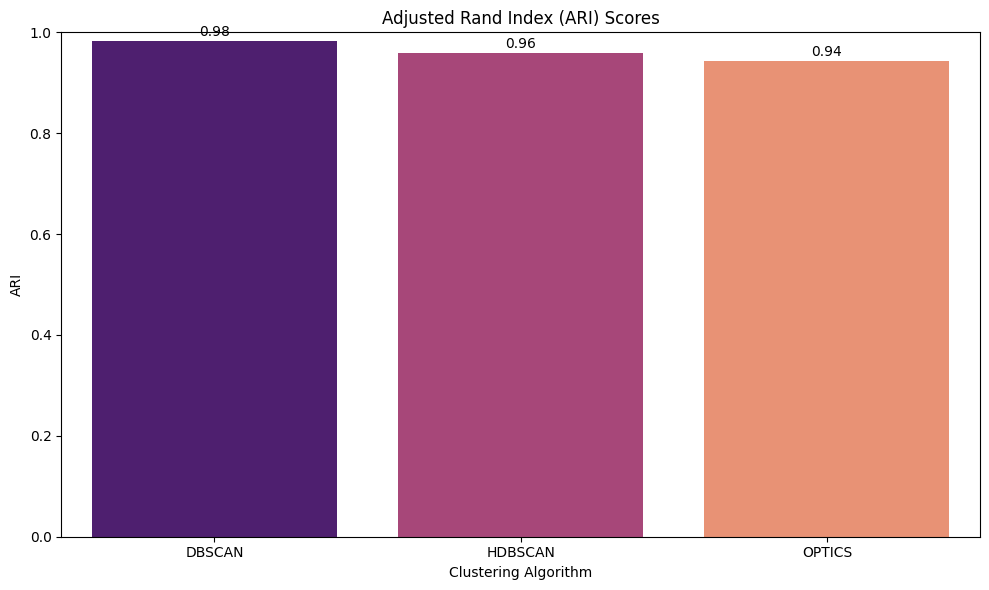

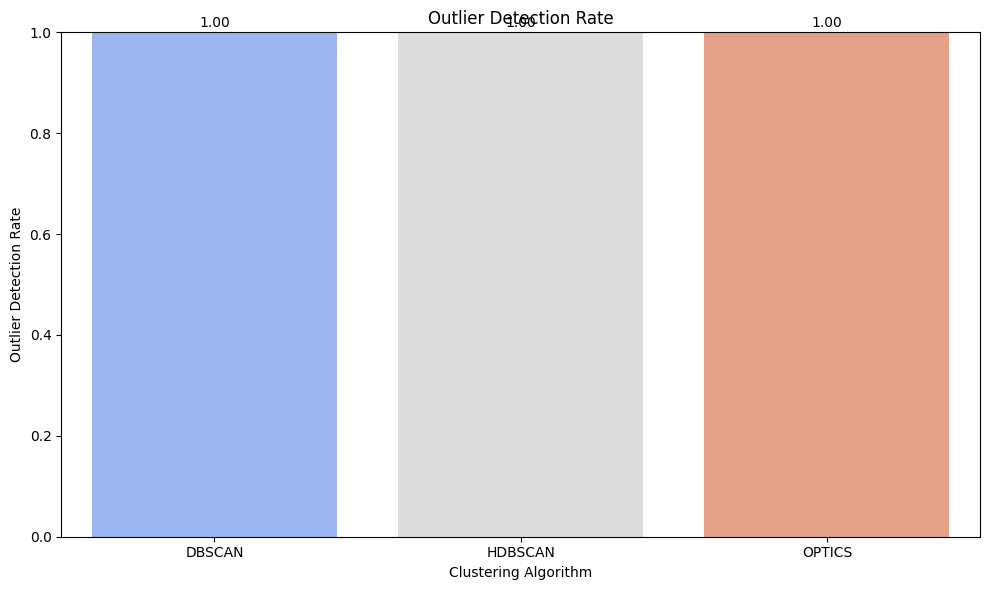

In [ ]:
file_path = 'Compound_fixed.txt'  # Example: 'synthetic_dataset.txt'
main(file_path)

Starting Hyperparameter Tuning and Evaluation...

Tuning DBSCAN...
Best DBSCAN - NMI: 0.8759, ARI: 0.9477, OutlierDet: 0.0000, Params: {'eps': 1.5, 'min_samples': 7}

Tuning HDBSCAN...
Best HDBSCAN - NMI: 0.8923, ARI: 0.9566, OutlierDet: 0.0000, Params: {'min_cluster_size': 8, 'min_samples': 19}

Tuning OPTICS...
Best OPTICS - NMI: 1.0000, ARI: 1.0000, OutlierDet: 0.0000, Params: {'min_samples': 7, 'xi': 0.2, 'min_cluster_size': 10}

===== Clustering Algorithms Comparison =====
  Algorithm       NMI       ARI  Outlier_Detection_Rate  \
0    DBSCAN  0.875871  0.947705                     0.0   
1   HDBSCAN  0.892277  0.956589                     0.0   
2    OPTICS  1.000000  1.000000                     0.0   

                                          Parameters  
0                     {'eps': 1.5, 'min_samples': 7}  
1         {'min_cluster_size': 8, 'min_samples': 19}  
2  {'min_samples': 7, 'xi': 0.2, 'min_cluster_siz...  


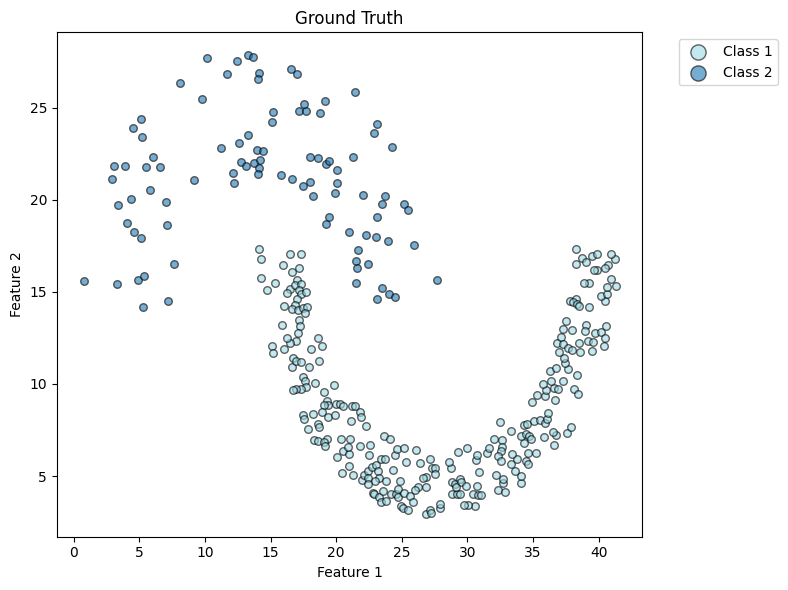

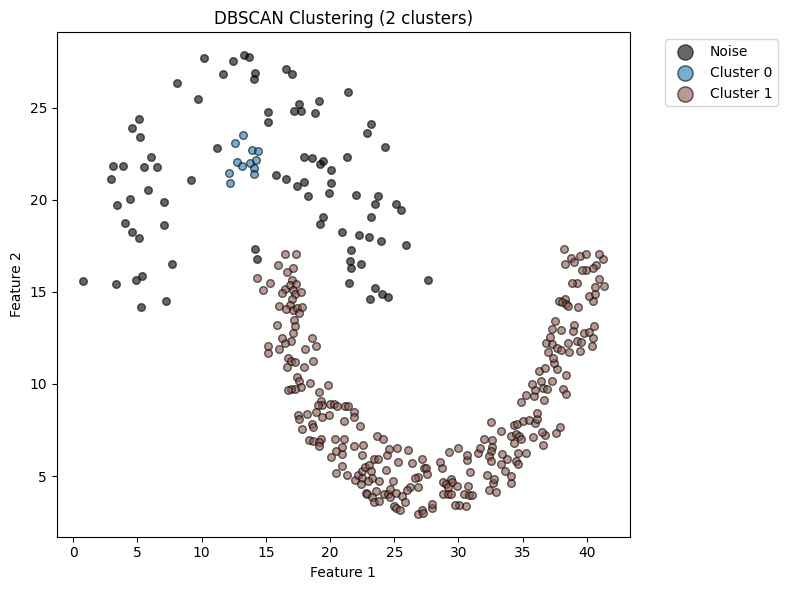

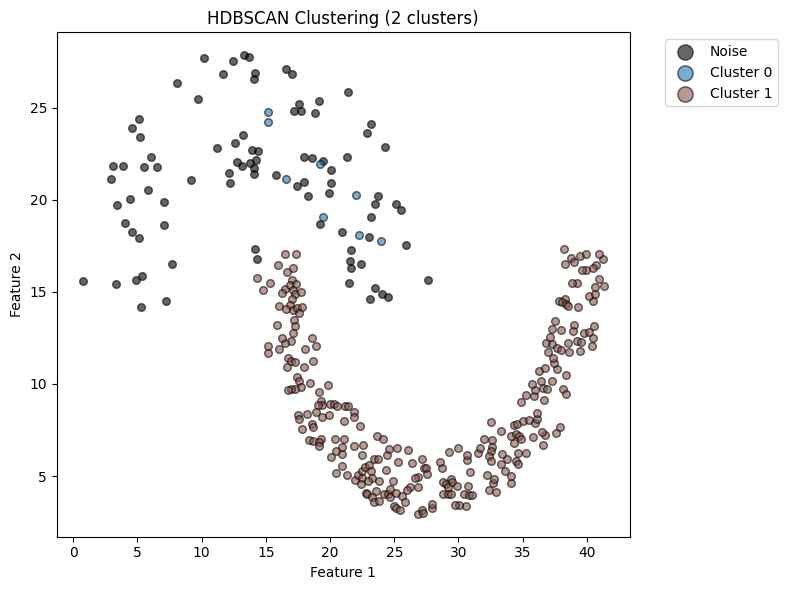

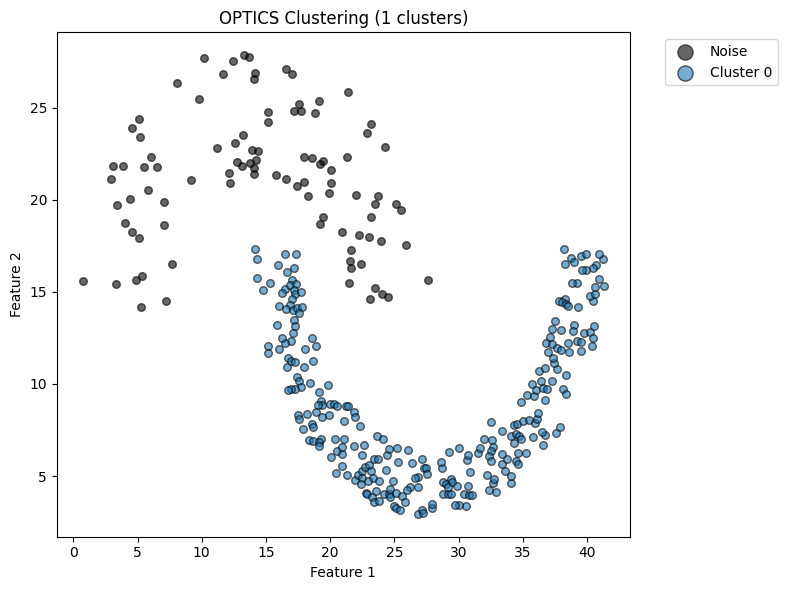


Results saved to 'clustering_comparison_results.csv'.


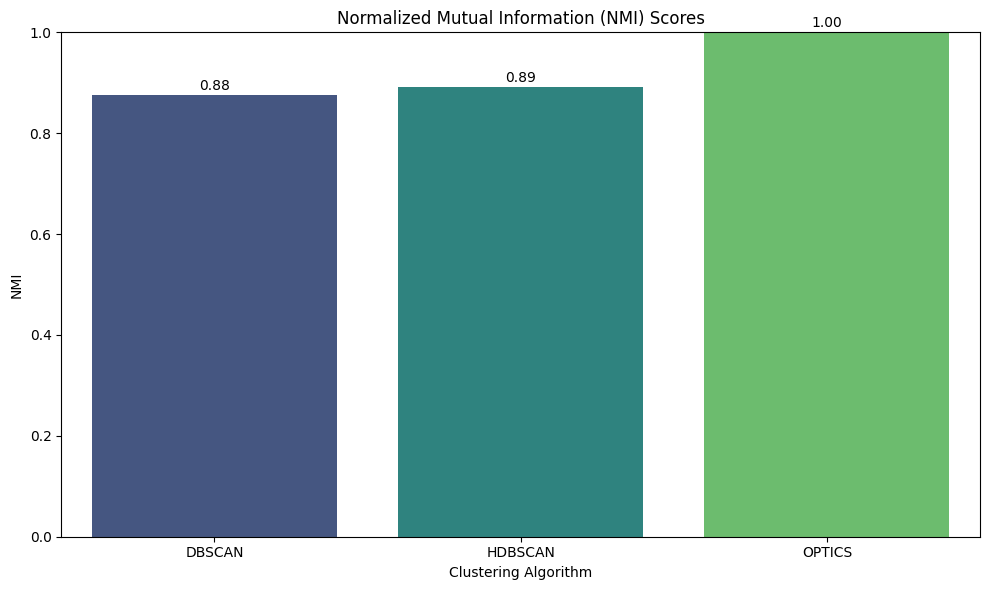

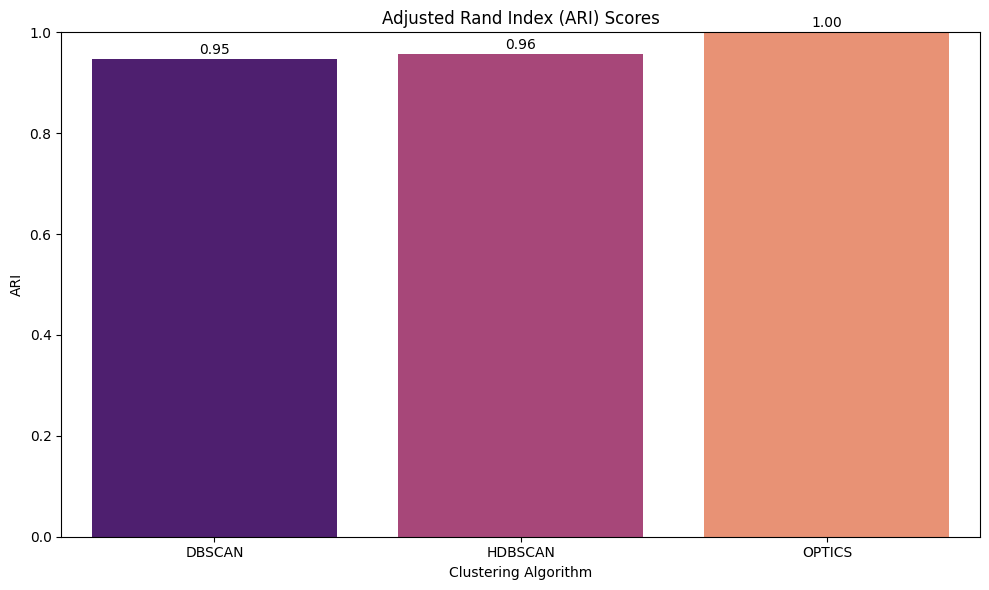

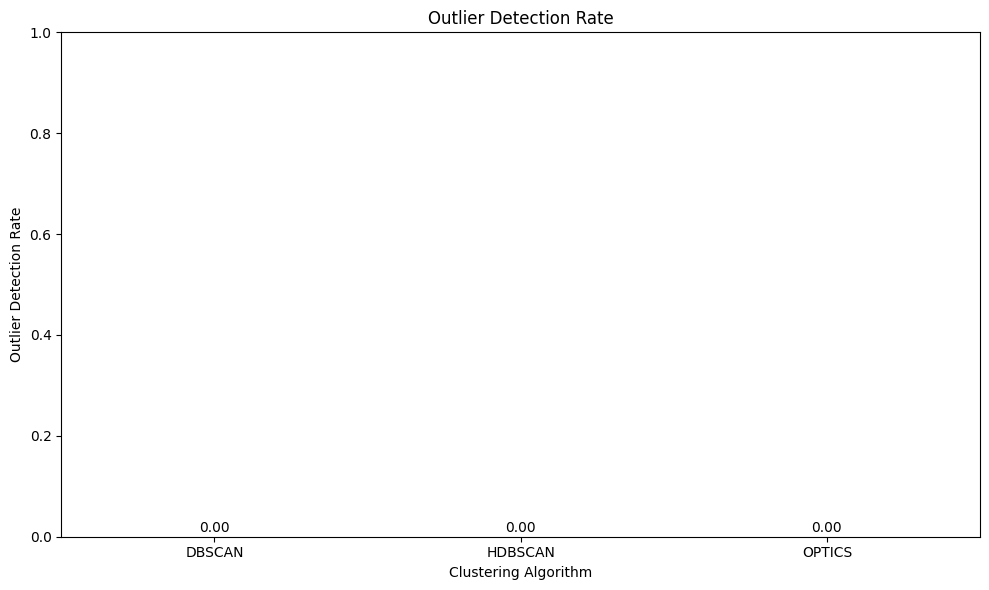

In [ ]:
file_path = 'jain.txt'
main(file_path)